## Practical 7: Spatial Data

Getting to grips with Geo-Data using Geopandas

Last week we did some initial processing on the Inside Airbnb listings
data, focussing on its *numeric* properties. This week we are going to
focus on the *spatial* properties of the data set.

> **Tip**
>
> It makes life a lot easier if you gather all of the library import
> commands and configuration information (here having to do with
> `matplotlib`) in the first exectuable code block in a notebook or
> script. That way it’s easy for you for others to see what what it is
> necessary to have installed before getting started!.

## 1. Preamble

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import matplotlib
import matplotlib.font_manager
# For debugging purposes (fonts can be hard)
print(matplotlib.get_cachedir())

# We change fonts the hard way in this notebook...
# but you can also do this to change the default 
# font everywhere in one go:
# matplotlib.rcParams['font.family'] = "Liberation Sans Narrow"
fontname = "Liberation Sans Narrow"

matplotlib.font_manager.FontManager().findfont(fontname, fontext='ttf', rebuild_if_missing=True)

/Users/jreades/.matplotlib

Matplotlib is building the font cache; this may take a moment.

'/Users/jreades/Library/Fonts/LiberationSansNarrow-Regular.ttf'

## 2. Reading Geo-Data

> **🔗 Connections**
>
> We’re building on the work done in [Practical
> 5](Practical-06-Numeric_Data.qmd) and [Practical
> 4](Practical-05-Objects.qmd) (with a particular nod to the [lecture on
> Data](https://jreades.github.io/fsds/sessions/week5.html#lectures)) to
> create some useful functions that we can call on at-need to improve
> the ease of doing data analysis.

I find GeoPackages and GeoParquet to be by far the easiest way to
distribute geo-data now: they are a single file (in a database-like
format that supports multiple types of data), include the projection
information by default, and in some cases QGIS can even embed
information about rendering style!

We’re going to do something *similar* to the `get_url` in order to
download the file to our hard drive and save it there. The improvement
is that we’ll check to see if the file already exists and, if it does,
return that so that you can don’t have to keep downloading it week after
week.

You’ll need to add the documentation yourself and I’ve left a few `??`
to challenge you.

### 2.1 Caching Remote Data

We don’t want to continually download data over the Internet: 1) because
it’s not nice to whoever is hosting the data; and 2) because it requires
you be online in order to run your code. So if we can ‘cache’ the data
locally so that it’s only downloaded once this makes life much, much
easier.

I’ve used the Numpy-style comments here, but the Google-style also look
good in this context and all styles of answer are acceptable so long as
they *work*. See overview of commenting styles [on
DataCamp](https://www.datacamp.com/community/tutorials/docstrings-python).

> **Tip**
>
> Use this as an opportunity to improve your ability to read code and to
> learn through documentation.

> **Difficulty level: Moderate**

##### 2.1.0.1 Question

In [ ]:
import os
from requests import get
from urllib.parse import urlparse

def cache_data(src:str, dest:str) -> str:
    """
    
    ??
    
    
    """    
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn  = os.path.split(url.path)[??] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename
    
    if not os.path.isfile(dfn) or os.path.getsize(dfn) < 250:
        
        print(f"{dfn} not found, downloading!")

        path = os.path.split(dest)
        
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
            
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(??.content)
            
        print("\tDone downloading...")

    else:
        print(f"Found {dfn} locally!")

    return dfn

help(cache_data) # <- This should show the docstring you've written

### 2.2 Downloading the Data

> **Difficulty level: Low, if your function works!**

#### 2.2.1 Geopackages

Use the function above to download and cache the GeoPackage files found
[on GitHub](https://github.com/jreades/fsds/tree/master/data/src) for
Boroughs, Water, and Greenspace, then pass the output of these to
GeoPandas. If you have been having trouble downloading files from
GitHub, then use the understanding of the function developed above to
download the file manually and place it where this function expects to
find it!

##### 2.2.1.1 Question

In [ ]:
ddir  = os.path.join('data','geo') # destination directory
spath = 'https://github.com/jreades/i2p/blob/master/data/src/' # source path

boros = gpd.read_file( ??(spath+'Boroughs.gpkg?raw=true', ddir) )
water = gpd.read_file( ??(spath+'Water.gpkg?raw=true', ddir) )
green = gpd.read_file( ??(spath+'Greenspace.gpkg?raw=true', ddir) )

print('Done.')

#### 2.2.2 Parquet

Let’s re-use our `cache_data` function to download and save the full
Inside Airbnb data set. Again, if you have trouble with downloading via
code, use your understanding of the function to work out where to save
your own copy of this file so that the function works as expected.

> **Difficulty level: Low**

In [7]:
ymd  = '20240614'
city = 'London'
host = 'https://orca.casa.ucl.ac.uk'
url  = f'{host}/~jreades/data/{ymd}-{city}-listings.parquet'

##### 2.2.2.1 Question

In [ ]:
# your code here
df = pd.read_parquet( ??(??, os.path.join('data','raw')) )
print(f"Data frame is {df.shape[0]:,} x {df.shape[1]}")

You should see that the file was ‘not found’ so ‘downloading’ happened
and then the size of the data frame was printed out.

## 3. ‘Writing’ Geo-Data

Of course, you will also often encounter geo-data that is not yet
‘geographically enabled’; the two most frequent contexts for this are:

1.  The data represents points and is provided with latitude and
    longitude (or similar) as separate columns in a non-geographic data
    set.
2.  The data represents polygons but is provided *separately* from the
    polygons themselves and so cannot be shown on a map without being
    ‘joined’ to the geography first.

We’ll tackle each of these eventually, but for now we’re going to focus
on the first option.

### 3.1 Creating a GeoDataFrame

> **Difficulty Level: Low**

Right, we’re finally there! We need to convert our coordinates into some
kind of geo-data. GeoPandas offers two ways to do this: the original way
using `zip` and a new utility method called `points_from_xy`. Here’s the
old way:

``` python
from shapely.geometry import Point
gdf = gpd.GeoDataFrame(df, 
                geometry=[Point(x,y) for x, y in zip(df.Longitude,df.Latitude)])
```

Note, however, that this did not automatically set a projection, unlike
the new approach with the ‘helper function’:

In [10]:
gdf = gpd.GeoDataFrame(df,
      geometry=gpd.points_from_xy(df.longitude, df.latitude, crs='epsg:4326'))

In [11]:
print(type(gdf))
print(type(gdf.geometry))

<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geoseries.GeoSeries'>

### 3.2 Saving Geo-Data Locally

#### 3.2.1 Think Storage Formats

We want to save the InsideAirbnb GeoDataFrame to the ‘geo’ directory,
but first let’s see [what file formats are
supported](https://geopandas.org/en/stable/docs/user_guide/io.html).

| Format | Advantages | Disadvantages |
|:----------------|:---------------------------|:---------------------------|
| Shapefile | Wide support | Easy to break via loss of individual file element and not very efficient format |
| GeoJSON | Human-readable | Highly inefficient storage format |
| GeoPackage | Lightweight spatial database with benefits of indexing | Lightweight spatial database with limits on data types supported |
| Parquet | Highly compressed columnar database | Limited GIS support (except QGIS) |

**GeoPackages** are really well-supported by QGIS: you can even embed
multiple layers with different style information so that your final
analysis is easy to distribute; however, they also carry quite a bit of
overhead that makes them inefficient for distributing smaller data sets,
while *also* not supporting the full spectrum of Pythonic data
structures such as categorical data or lists.

**GeoParquet** is an extension of the Parquet format. For working with
large data sets this has revolutionised my workflow: getting excited
about a columnar database might seem a bit… nerdy… but it’s been
transformative for many data scientists. First, because the data set is
columnar you only read in the data that you need, so reading Parquet
file is blindingly fast. Second, you can stream data from a Parquet file
over the Internet, so that means you even gain these advantages reading
remote files. Third, you have full support for Python data types,
including (up to a point) objects. And, fourth, you can treat multiple
Parquet files with the same layout as a single data set or mutiple
Parquet files with different layouts as tables in a single database!

#### 3.2.2 Specifying a Driver

Since there are *many* formats in which to save geo-data, rather than
have multiple `to_format_x` methods, GeoPandas has *one* for local files
(`to_file`). If you are reading/writing a filename than ends in a valid
extension (e.g. `.shp`, `.gpkg`, or `.geojson`) then GeoPandas will ‘do
the right thing’. Where you *may* run into trouble is if you are
reading/writing a **URL**
(e.g. <https://github.com/jreades/fsds/blob/master/data/src/Boroughs.gpkg?raw=true>).
With a URL ending in `?raw=true` there’s no extension that GeoPandas can
see so you *will* need to specify a driver. If in doubt, specify the
driver.

> **Clarification**
>
> In this practical we are reading geodata from GitHub and I’m saying
> that we need to specify the driver. So why didn’t we need to do with
> the `cache_data` function earlier as well? Well, this was a
> side-benefit of using the standard URL library: it *automatically*
> stripped off the query string (`?raw=true`) when I asked it for the
> file name, so we saved the file locally as a GeoPackage with `.gpkg`
> extension, which means that GeoPandas could read it without any
> problems.

So the following two bits of code are equivalent:

In [12]:
# This *may* not always do what we want, but should be fine for local files
boros.to_file('test.gpkg') 

In [13]:
# This is safer if working across computers/the Internet
boros.to_file('test.gpkg', driver='GPKG')

So, starting with <code>fn = ‘20240614-listings.gpkg’</code>

Notice the difference:

In [16]:
print(f"Using '{fn}' as basis for saving data...")
try:
   gdf.to_file(os.path.join('data','geo',fn), driver='GPKG')
except TypeError as e:
    print("Caught type error...")
    print(str(e)[:1000] + " ...")

Using '20240614-listings.gpkg' as basis for saving data...

If you try to save as a GeoPackage file then the code above typically
throws a `TypeError` because of the presence of Categorical data.

But the below, in which we specify as a ‘geoparquet’ because of the
coordinate data, does not:

In [17]:
fn = fn.replace('.gpkg','.geoparquet')
gdf.to_parquet(os.path.join('data','geo',fn))
print("Saved.")

Saved.

### 3.3 Spatial Indexing

It’s also worth comparing the output of a point with the output of a
polygon or multi-polygon because you may well come across data in
formats (e.g. WKT) resembling both of these in real data sets and they
*can* be read as well. Notice too that we can use `loc` and `iloc`
accessor methods to pull individual points and polygons out of a
GeoDataFrame!

In [18]:
print(gdf.geometry.iloc[1]) # Print out the object's contents
gdf.geometry.iloc[1] # The object knows how to print itself as a point

POINT (-0.21707 51.49993)

In [19]:
# Object to string then print out first 399 characters
print(str(boros.geometry.iloc[1])[:399] + "...") 
# So this is a multi-polygon boundary
boros.geometry.iloc[1] 

MULTIPOLYGON (((535009.2 159504.7, 535005.5 159502, 535002.9 159500.1, 535000.1 159503.2, 535000 159503.2, 534747.8 159517.8, 534588 159522.1, 534512.3 159780.5, 534474.8 159760.8, 534398.8 159726.7, 534391.9 159723.3, 534378.9 159712.4, 534345.1 159702.8, 534314.3 159691.8, 534292.7 159683.9, 534253.1 159666.6, 534229.4 159657.9, 534207.5 159654.6, 534160.5 159651.5, 534159.7 159637.1, 534109.5 ...

So each element of this Series has text indicating the type of shape the
geometry applies to (e.g. *POLYGON*) followed by a bunch of numbers.
These numbers are truncated here just to make things a little more
legible.

## 4. Checking the Data

#### 4.0.1 Checking Numeric Data

Before we mindlessly convert the parquet data to mappable geo-data it
might make sense to sanity-check it. GeoPandas has a `total_bounds`
method that gives us the bounding box for a GeoSeries, but how would we
do that in Pandas?

> **Tip**
>
> Think about what the ‘total bounds’ (or ‘envelope’) of a point data
> set is. You have already seen the pandas functions you’ll need to
> *find* these…

> **Difficulty level: Moderate**

##### 4.0.1.1 Question

In [ ]:
print(f"The bottom-left corner is {??}, {??}")
print(f"The top-right corner is {??}, {??}")

Your answer should produce the following:

The bottom-left corner is -0.5, 51.3

The top-right corner is 0.3, 51.7

#### 4.0.2 Checking via a Plot

> **Difficulty level: Low**

We’ll see how you control figure-making more effectively later, but for
now let’s just see what they look like using GeoPanda’s plotting
functionality. If you don’t see what you expected then the problem could
be quite basic/fundamental.

##### 4.0.2.1 Question

In [ ]:
for ??:
    ??.plot()

#### 4.0.3 Checking the Projection

> **Difficulty level: Low**

Check the projection of each GeoDataFrame using a for loop and the `crs`
attribute.

##### 4.0.3.1 Question

In [ ]:
for g in [??]:
    print(g.??)

You should see that all three are in the [EPSG:27700
CRS](https://epsg.io/27700) which is a common one for analysis using GB
data.

#### 4.0.4 Reprojecting the Data

> **Difficulty Level: Low**

Let’s start by taking our InsideAirbnb data in its original projection…

In [24]:
print(gdf.geometry.crs)
print(gdf.total_bounds)

epsg:4326
[-0.4978     51.295937    0.29573069 51.6816423 ]

… and reprojecting this into the `OSGB1936/BNG` CRS:

##### 4.0.4.1 Question

In [ ]:
gdf = gdf.??(??) # There is no 'in_place=True' option here.
print(gdf.geometry.crs)
print(gdf.total_bounds)

Notice the change in total bounds from lat/long to Northing/Easting.

## 5. Simple Mapping

The files we’ve just downloaded all contain polygons, and the
adjustments for points are different, but it’s worth seeing how you can
tweak these before we start combining them. Behind the scenes, GeoPandas
is using `matplotlib` to render the map, so let’s play with the colours
to get the *start* of something map-like.

You will want to look both at [how to make maps in
GeoPandas](https://geopandas.org/mapping.html) and at the different ways
to [specify colours in
Matplotlib](https://matplotlib.org/3.1.1/tutorials/colors/colors.html#specifying-colors).
For the greenspace map you are looking for information about tuples…
which can have three or four elements.

### 5.1 Work Out the Colour Scheme

> **Difficulty level: Moderate**

> **Caution**
>
> R and Python take *very* different approaches to plotting. Do *not*
> think of Python’s output as being ‘maps’ in the GIS sense, they are
> composed of ‘patches’ of color on abstract ‘axes’ that can use any
> arbitrary coordinate space. So colours are ‘really’ triplet (or
> quadruplet if you have alpha-blending transparency) values in the
> range 0.0-1.0. Annotations are then added in similarly abstract
> fashion.

I’d **suggest** the following colour scheme as a way to test out
different ways of specifying colour (though anything you like is fine so
long as you manipulate the colours):

-   The boroughs can have red edges and white fill with a thick edge.
-   The water should have no edges and XKCD Lightblue fill.
-   The greenspace should have edges and faces specified using different
    ‘alpha blending’ (i.e. transparency) levels.

#### 5.1.1 Boroughs

By way of a hint, matplotlib uses `edgecolor` and `facecolor` for
controlling ‘patches’ (which is what polygons are considered), but the
thicker-than-default line-width is specified differently (you’ll need to
look this up). So the intention is:

1.  Thick red borough borders, and
2.  White fill colour.

Just to drive home how different this is from R, you can find the answer
to question 1 [on the page for bar
plots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html).

##### 5.1.1.1 Question

In [ ]:
boros.plot(??)

Your plot should look similar to this:

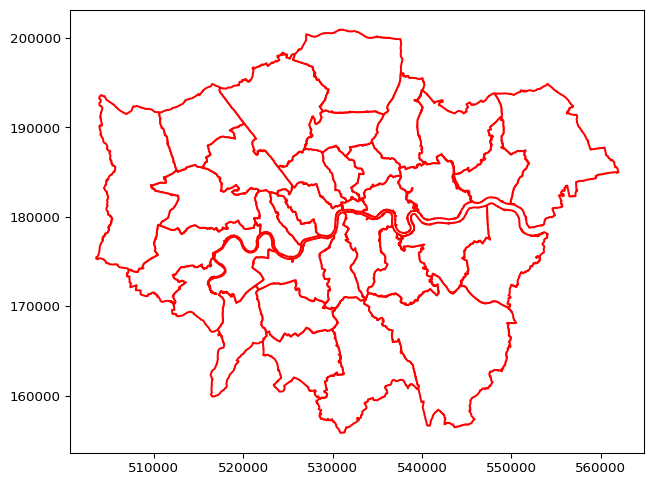

#### 5.1.2 Water

The process is the same as above, but I’d like you to work out how to
specify: 1. *No* color for an edge, and 2. An XKCD color for the face.

##### 5.1.2.1 Question

In [ ]:
water.plot(??)

Your plot should look similar to this:

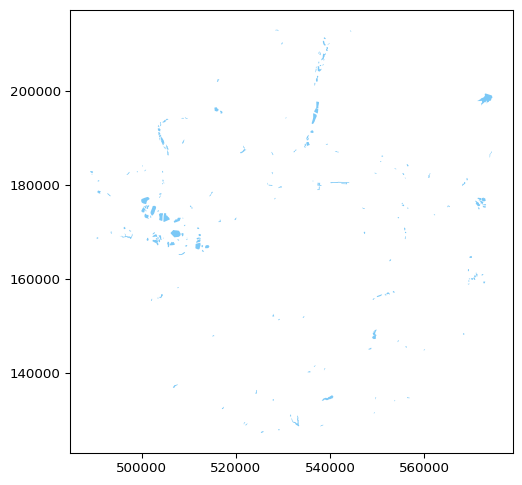

#### 5.1.3 Greenspace

The process is *also* the same as above, but I’d like you to work out
how to specify colours and transparency using RGBA (red-green-blue-alpha
transparency) tuples. So we’re looking for: 1. No edge color. 2. A
partially transparent green specified as a ‘tuple’ (4 numbers in
parentheses in the range 0.0-1.0).

##### 5.1.3.1 Question

In [ ]:
green.plot(??)

Your plot should look similar to this:

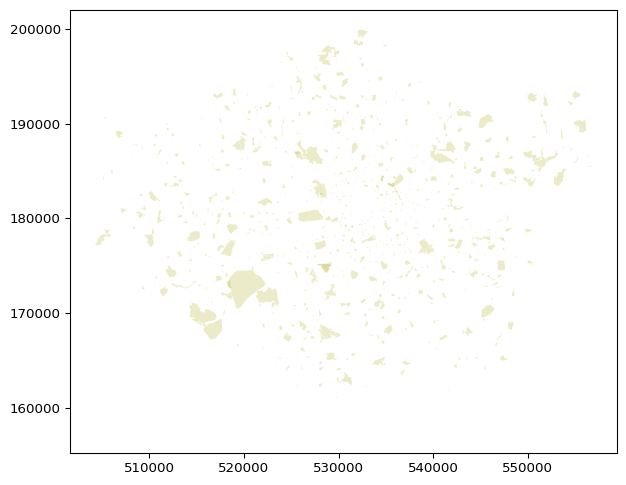

### 5.2 Combining Layers

> **Warning**
>
> R and Python take *very* different approaches to plotting. Do *not*
> think of Python’s output as being ‘maps’ in the GIS sense, they are
> composed of ‘patches’ of color on abstract ‘axes’ that can use any
> arbitrary coordinate space. So colours are ‘really’ numerical triplets
> (or quadruplets if you have transparency as well) in the range
> 0.0-1.0. Annotations are then added in similarly abstract fashion.

Now that we’ve got our layers looking roughly how we want them, it’s
time to combine them. This is also reliant on `matplotlib` and basically
involves plotting items to *shared axes* which is done by passing in
`ax=<axis object>` to each `plot(...)`. By convention, if you only have
a single figure (e.g. a single map) then you create an axis object and
name it `ax` so you will see a lot of `ax=ax` code in graphing
libraries, but `=ax` is just saying ‘assign to the axis object that I
created’.

Since the axes are how you control what is shown, see if you can find
out by Googling how to set the x- and y-limits on the map so that it
shows only London and trims out the much larger area of water that is
outside of the Greater London Authority. **As a rough guideline, this
has the Easting range 501,000 to 563,000, and the Northing range 155,000
to 202,000.**

You can set these limits before or after you start adding layers to the
‘map’, but it’s probably easier conceptually to add them after with the
idea of ‘zooming in’ on the features of interest. It’s also easier to
debug since you can start by seeing if you can plot the elements at all,
and *then* add the limits to zoom.

**So the steps are:**

1.  Write the code to plot every image on the same set of axes (I’ve
    given you something to get started).
2.  Google how to set the limits of the map and then use the ranges I’ve
    offered above.
3.  Work out how to change the width of the edges for the boroughs
    layer.
4.  Save it somewhere local so that you could, say, load it into a
    Markdown file!

> **Tip**
>
> This is a first pass at a map, over the next few weeks we’ll see how
> to add things like axis labels and titles to make it more ‘map-like’.
> We don’t have quite the built-in functionality of `ggplot` alas, but
> Python is advancing very quickly in this area. There is even [an
> implementation of ggplot in Python](https://github.com/yhat/ggpy), but
> it’s functionality is more limited. In fact, there’s [more than
> one](https://github.com/has2k1/plotnine)…

> **Difficulty level: Hard**

##### 5.2.0.1 Question

In [ ]:
# Creates a new figure with specified number of
# subplots (we'll see more of this later) and 
# and the specified size (in inches by default).
fig, ax = plt.subplots(1,1, figsize=(8,6))

# Plot all three GeoPackages to the same axes
water.plot(??, ax=ax)
green.??
boros.??

# Set the x and y limits


# Save the image (dpi is 'dots per inch')
os.??('img', exist_ok=True)
plt.savefig(os.path.join('img','My_First_Map.png'), dpi=150)

You may wish for a different look, but here’s one version of the output:

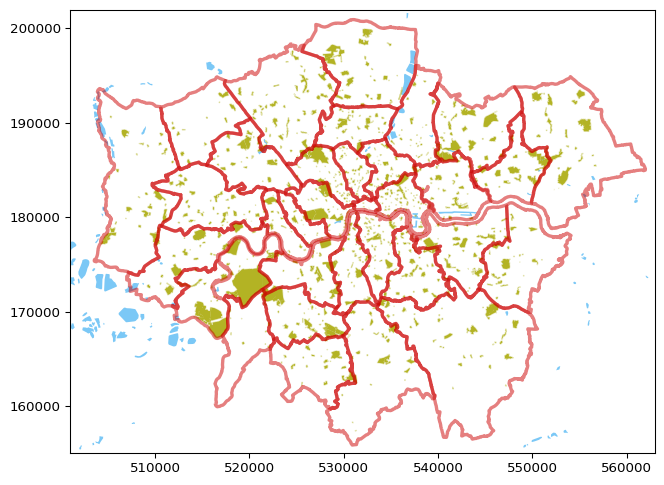

### 5.3 Choropleth Plots

> **Difficulty Level: Low**

Now that we’ve converted the InsideAirbnb data to a GeoDataFrame, we can
plot it, reproject it, etc.

See if you can work out how to plot the points coloured by their price
using the appropriate BNG projection.

##### 5.3.0.1 Question

In [ ]:
gdf.to_crs(??).plot(column=??, cmap=??, alpha=0.25, markersize=1, figsize=(8,6));

Using the Viridis colourmap I get the following:

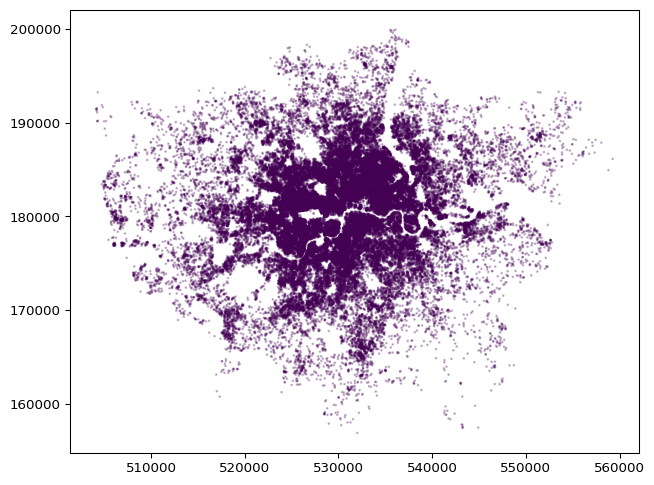

#### 5.3.1 Work out the Data Range

> **Difficulty level: Low**

As we saw above with the point-plot, in its original form the pricing
data will not reveal much of interest because of the range of the data.
However, as you will have seen in QM already (and as we explore in
greater detail in Weeks 7/8), using *transformations* we can manipulate
the data to increase its tractability for analysis.

Let’s start by getting a feel for the full data set in terms of the
range of prices that it contains:

##### 5.3.1.1 Question

In [ ]:
print(f"The range of price is ${??:,.2f} to ${??:,.2f}")
print(f"The mean and median of the price are ${??:,.2f} and ${??:,.2f}")

Notice the neat little comma-separated thousands in there? That’s fairly
easy to do in English, but to use a thousands separator common to
another language you would need to do something [a little more
tricky](https://stackoverflow.com/questions/13082620/how-can-i-print-a-float-with-thousands-separators).

#### 5.3.2 Inheritance!

We already know that GeoPandas *inherits* functionality from Pandas, but
let’s formalise this…

First, let’s check what class of object `gdf` is using the
[`isinstance`](https://www.w3schools.com/python/ref_func_isinstance.asp)
function:

In [37]:
# Is gdf a GeoDataFrame object?
if isinstance(gdf, gpd.GeoDataFrame): 
    print("\tI'm a geopandas data frame!")

# Is gdf *also* a DataFrame object?
if isinstance(gdf, pd.DataFrame): 
    print("\tI'm a pandas data frame!")

    I'm a geopandas data frame!
    I'm a pandas data frame!

#### 5.3.3 Benefiting from Inheritance

*That* result means that we can also investigate the data using, for
instance, a pandas histogram:

##### 5.3.3.1 Question

In [ ]:
# Oooooh, let's use a *pandas* method here
gdf.price.plot.??(bins=??, figsize=(8,3)); 

Notice how we’ve used our GeoDataFrame *as if* it’s a plain old
DataFrame here? That’s the miracle of Object-Oriented Design: we can do
*anything* we would with a regular Pandas `df` as we do with a GeoPandas
`gdf` because GeoPandas *inherits* all the methods of its parent
super-class.

We can see that there’s very little data above (at a guess) about
\$2,000, but at this scale it’s hard to tell. We’ve already seen that
you can use axes limits to adjust the display of a map, but the same
technique applies to plain old plots because they’re fundamentally the
*same thing*.

Try adjusting the axis so that the x-range is 0..2500:

``` python
ax = gdf.price.plot.??(bins=??, figsize=(8,3));
ax.??
```

You can do the same thing with a boxplot:

##### 5.3.3.2 Question

In [ ]:
ax = gdf.price.plot.??(vert=False, figsize=(8,3))
ax.??

[More complex](https://stackoverflow.com/a/54023612/4041902) formatting
is also possible if you really know your pandas and your matplotlib:

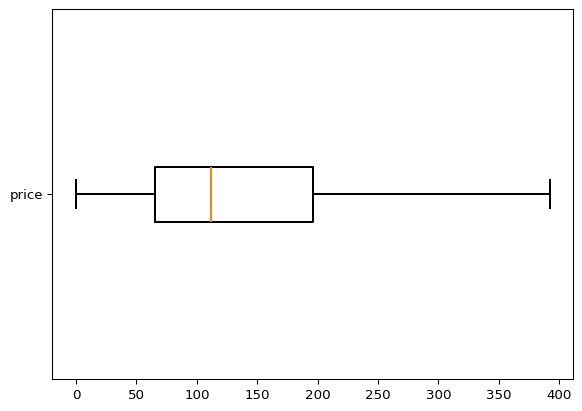

In [41]:
gdf.price.plot(kind='box', vert=False, 
             color=dict(boxes='r', whiskers='r', medians='r', caps='r'),
             boxprops=dict(linestyle='-', linewidth=1.5),
             flierprops=dict(linestyle='-', linewidth=1.5),
             medianprops=dict(linestyle='-', linewidth=1.5),
             whiskerprops=dict(linestyle='-', linewidth=1.5),
             capprops=dict(linestyle='-', linewidth=1.5),
             showfliers=False, grid=False, rot=0);

### 5.4 Truncate and Transform

> **Difficulty level: Hard**

#### 5.4.1 Working it Out

Anyway, drawing on everything we’ve seen over the past couple of weeks
(and in *this* practical) I’d like you to:

1.  Try to take the natural-log of the price (*hint*: use `numpy`) and
    assign to a new Series called `lnprice`.
2.  Work out what the error means.
3.  Work out how to fix the error and *then* repeate step 1.
4.  Work out how many rows were affected.
5.  Report on the new min/max values.
6.  Work out if other outliers need to be removed (use code from above).
7.  Remove outliers and then continue with your work…

``` python
# Use this as a 'scratch space' to work out what's needed below...
```

##### 5.4.1.1 Question

In [ ]:
print(f"gdf has {gdf.shape[0]:,.0f} rows.")

# ---------- Do the processing -------------
# You may need more than one of these 'drops'
# to get the data the way you want...
gdf.drop(gdf[??].index, axis=0, inplace=True)
gdf['lnprice'] = np.log(gdf.price)

# ---------- Check effects -----------
print(f"gdf now has {gdf.shape[0]:,.0f} rows.")
print(f"The range of price is {gdf.price.min():,.2f} to {gdf.price.max():,.2f}")
print(f"The range of ln(price) is {gdf.lnprice.min():,.4f} to {gdf.lnprice.max():,.4f}")

gdf.price.plot(kind='box', vert=False, 
             color=dict(boxes='r', whiskers='r', medians='r', caps='r'),
             boxprops=dict(linestyle='-', linewidth=1.5),
             flierprops=dict(linestyle='-', linewidth=1.5),
             medianprops=dict(linestyle='-', linewidth=1.5),
             whiskerprops=dict(linestyle='-', linewidth=1.5),
             capprops=dict(linestyle='-', linewidth=1.5),
             showfliers=False, grid=False, rot=0);
plt.title("Price (Outliers not shown)")
plt.show()

gdf.lnprice.plot(kind='box', vert=False, 
             color=dict(boxes='r', whiskers='r', medians='r', caps='r'),
             boxprops=dict(linestyle='-', linewidth=1.5),
             flierprops=dict(linestyle='-', linewidth=1.5),
             medianprops=dict(linestyle='-', linewidth=1.5),
             whiskerprops=dict(linestyle='-', linewidth=1.5),
             capprops=dict(linestyle='-', linewidth=1.5),
             showfliers=False, grid=False, rot=0);
plt.title("Ln(Price) (Outliers not shown)")
plt.show()

### 5.5 Plot Options

Now plot the ln(price) as a chloropleth using:

1.  A figure size of 9 x 6
2.  A marker size of 0.25
3.  The Viridis colourmap
4.  A legend
5.  A legend label of ‘Natural Log of Price per Night (\$)’

I’d suggest [referring to the
documentation](https://geopandas.org/mapping.html).

##### 5.5.0.1 Question

In [ ]:
ax = gdf.plot(figsize=??, marker='*', markersize=0.25, 
         column=??, cmap=??, 
         legend=??, legend_kwds=??);
ax.set_title("Plot of Natural Log of Nightly Price for Airbnb Listings (Outliers Removed)");

You should get something like:

### 5.6 Zooming In/Out

> **Difficulty Level: Low**

That’s a little hard to see, let’s try zooming in on Central London!
Very roughly, let’s call that an Easting range of 525,000 to 535,000 and
a Northing range of 178,000 to 185,000.

> **Plotting**
>
> We show one way to do this below (`f,ax = plt.subplots(...)`) because
> it gives you greater control, but `gdf.plot()` *can* return an axis
> object (`ax = gdf.plot(...)`) that gives you the same kind of access…
> but with a bit more ‘faff’.

##### 5.6.0.1 Question

In [ ]:
# Note this new f,ax syntax and that we then
# pass ax=ax to gdf.plot -- this has to do with
# where and how things are plotted.
f,ax = plt.subplots(1,1,figsize=(8,6))
gdf.plot(ax=ax, marker='*', markersize=0.25, 
         column='lnprice', cmap='viridis', 
         legend=True, legend_kwds={'label':'Natural Log of Price per Night ($)'});
ax.set_title("Ln(Price/Night) for Airbnb Listings (Central London Detail)")
ax.??
ax.??
f

Your result should look something like this:

That’s a little better, but ideally we’d do more thinking about
outliers…

### 5.7 Changing the Classification Scheme

> **Difficulty Level: Moderate (mainly computation time)**

Let’s give this one last try using the quantiles classification scheme
for Central London!

##### 5.7.0.1 Question

In [ ]:
f,ax = plt.subplots(1,1,figsize=(8,6))
ax = gdf.plot(marker='*', markersize=0.25, 
         column='lnprice', cmap='viridis', ??, k=5, 
         legend=True, ax=ax); 
         # Note that the legend *label* had to go -- 
         # there are other ways to add it.

ax.set_xlim([525000,535000])
ax.set_ylim([178000,185000])

Your answer should look like:

## 6. Simple Web Maps

> **Difficulty Level: Hard**

This is more for the sake of demonstrating Python’s features than
because it’s part of my workflow, but what the heck, let’s do it! We
will create and embed a zoomable web map in the notebook; to do *that*
we need to:

1.  Calculate the bounds of the map using the min/max x and y
    coordinates above.
2.  Calculate the centroid of the map from the bounds.
3.  Set an appropriate zoom level.

If your work is going well, perhaps you may also want to experiment with
[different
basemaps](https://ipyleaflet.readthedocs.io/en/latest/api_reference/basemaps.html).

> **Tip**
>
> You can’t use `round` here because it it could round up or down
> depending on what’s closest and, consequently, cut off data on your
> map. So you’ll have to look for two *other* functions that do this
> predictably (e.g. always rounding down, even if the value is
> 4.999999). However, those functions don’t handle decimals like `round`
> does, so you need to think about how you could turn a number like 4.99
> into a number that those functions *can* work with and then turn it
> *back* into the decimal…

##### 6.0.0.1 Question

In [ ]:
from math import floor, ceil

# Calculate min and max to *two* decimal places
xmin = ??
xmax = ??
ymin = ??
ymax = ??

# Print them to *3* decimal places to check they end in 0
print(f"{xmin:.3f}, {xmax:.3f}, {ymin:.3f}, {ymax:.3f}")

# Calculate the centre of the map
yctr = ??
xctr = ??

# Print this two ways to see an intriguing issue
print(f"{xctr:.5f}, {yctr:.5f}")
print(xctr, yctr)

You should end up with something like:

In [ ]:
-0.530, 0.310, 51.270, 51.710
-0.11000, 51.49000
-0.10999999999999999 51.49

You’ll see *why* this happens in the answer.

If you’ve managed the calculations above, then this code should simply
run!

In [50]:
from ipyleaflet import Map, basemaps, basemap_to_tiles, Rectangle, projections

# Note the basemap can be easily changed
watercolor = basemap_to_tiles(basemaps.OpenStreetMap.HOT)

m = Map(layers=(watercolor, ), center=(yctr, xctr), zoom=8)

rectangle = Rectangle(bounds=( (ymin, xmin), (ymax, xmax) ),
    crs=projections.EPSG4326
)

m.add_layer(rectangle)

m

Your map should look like this:

## 7. Bringing it All Together

> **Difficulty Level: 🤯**

To give a bit of a show of how we can put it all together try to get
this working

##### 7.0.0.1 Question

In [ ]:
import pysal as p
import mapclassify as mc
import palettable.matplotlib as palmpl
from legendgram import legendgram

# We create a temporary data frame here because we want
# the 'bins' to be created using only the data on the 
# map. Otherwise, we'd have a distribution on the map 
# that differed from the one in the legendgram and the
# one used to calculate the breaks in the first place!
tgdf = gdf[(gdf.geometry.x > 525000) & (gdf.geometry.x < 540000) & (gdf.geometry.y > 176000) & (gdf.geometry.y < 186000)].copy()

# Here we use Mapclassify to calculate quantiles
# (k=5) using the original price. You could use
# any Mapclassify scheme at this point, though
# note that for Fisher Jenks you might want to use
# the 'Sampled' version to speed things up a bit.
q = mc.??(tgdf.price.values, ??)

# We then write these binned values *back* on to the data
# frame so that we can use them with the GDF plot function.
tgdf['bins'] = q.??

# Set up the figure with its 'basemap'
f,ax = plt.subplots(figsize=(8,6))
green.plot(edgecolor=(0.7, 0.7, 0.14, 0.25), facecolor=(0.7, 0.7, 0.14, 0.25), zorder=1, ax=ax)
water.plot(edgecolor="none", facecolor='xkcd:lightblue', zorder=2, ax=ax)
boros.plot(edgecolor=(0.8, 0, 0, 0.5), facecolor='none', linewidth=2.5, zorder=3, ax=ax)

# Restrict the x and y axis to the data
# Notice it's hard-coded here *and* above
# this could be done *better* using a 
# custom bounding box so that we could 
# update both the tgdf and the display
# area at the same time.
ax.set_xlim([525000,540000])
ax.set_ylim([176000,186000])

ax.axis(??) # Don't plot the axes

# Plot the bins using a categorical legend instead
# of the price using a continuous legend.
tgdf.plot(column='bins', categorical=True,
         cmap='viridis', legend=True, marker='.', markersize=1.5, zorder=4, ax=ax)

# Set the title using a specified font, weight, and size
ax.set_title('London Airbnb Listings Price Per Night', 
             fontdict={'fontsize':'20', 'fontweight':'3', 'family':fontname})  #provide a title

# This is where geopandas gets in the way -- the 
# categorical legend doesn't work for us so we need
# to actually create the legend 'by hand' using this 
# code... which first has to *find* the layer containing
# the data! Each layer is a 'patch collection', so we 
# loop through the collections looking for the one whose
# z-order is 4 (which we set above to the data layer).
#
# I relied on this: https://stackoverflow.com/a/71419387/4041902
# to work out how to do this!
for c in ax.collections:
    # Find the layer with the data
    if c.get_zorder()==4:
        # *Now* we can create a legend... but we need to 
        # first retrieve the colours from the layer. These
        # are returned as 'handles' and then we need to 
        # associate these with the labels taken from the
        # Mapclassify object... Once we set that up, along
        # with fonts and such, we can add it as an 'artist'
        # to the figure.
        handles, _ = c.legend_elements(prop="colors")
        legend1 = ax.legend(handles, q.get_legend_classes(fmt='{:.2f}'), 
                            loc="upper right", title="Price per Night", 
                            prop={'size':'10', 'weight':'1', 'family':fontname})
        ax.add_artist(legend1)

# And don't forget to add a source!
a = ax.text(tgdf.geometry.x.max(), tgdf.geometry.y.min(), 'Source: InsideAirbnb (2022)', 
             horizontalalignment='right', verticalalignment='bottom', 
             fontsize=14, fontweight=4, color='#333333', family=fontname)

# And this is a nice feature: show the distribution!
ax2 = legendgram(f, ax, 
           tgdf.??, q.??, bins=round(gdf.price.max()/25),
           pal=palmpl.Viridis_5,
           legend_size=(0.3, 0.1), 
           loc='lower left',
           clip=(0,1000),
           frameon=True
    )
# But we have to fix the font manually here
# for the legendgram too
for tk in ax2.get_xticklabels():
    tk.set_fontname(fontname)
    
#plt.savefig('Airbnb-price-all.png', dpi=150)

You should have something like this:

I’ll be honest, I do find ggplot easier for making good-quality; this
*is* more customisable overall, but it’s also much more ‘magical’ in the
sense of ‘search for `matplotlib` examples that do what you want then
copy+paste them and tweak’ being the main way that most people get
things working how they want.

Scalebars are awkward, and there’s now a library that can help with this
[on GitHub](https://github.com/ppinard/matplotlib-scalebar) that I’ve
installed. But I’ll leave that one to you.

> **Tip**
>
> You can find a lot of *possible* solutions in [this Stackoverflow
> thread](https://stackoverflow.com/questions/32333870/how-can-i-show-a-km-ruler-on-a-cartopy-matplotlib-plot)
> that *should* work without needing to install new libraries but I’ve
> not had a chance to test them each individually. You would undoubtedly
> want to put this in an external package and import it when needed
> rather than paste this code into every file. But you might find it
> easier to *test* the solutions by pasting. If you’re looking for glory
> (and my gratitude) then working out which of these is most
> generalisable (i.e. would work with both lat/long *and* OSGB
> coordinates) would be quite the challenge!

#### 7.0.1 Getting More Help/Applications

A great resource for more help and more examples is Dani Arribas-Bel’s
*Geographic Data Science* module: he has put all of his [module
practicals online](https://github.com/darribas/gds_course) (as we have
too), and you might find that something that he does makes more sense to
you than what we’ve done… check it out!

### 7.1 Credits!

##### 7.1.0.1 Contributors:

The following individuals have contributed to these teaching materials:
Jon Reades (j.reades@ucl.ac.uk), James Millington
(james.millington@kcl.ac.uk)

##### 7.1.0.2 License

These teaching materials are licensed under a mix of [The MIT
License](https://opensource.org/licenses/mit-license.php) and the
[Creative Commons Attribution-NonCommercial-ShareAlike 4.0
license](https://creativecommons.org/licenses/by-nc-sa/4.0/).

##### 7.1.0.3 Acknowledgements:

Supported by the [Royal Geographical
Society](https://www.rgs.org/HomePage.htm) (with the Institute of
British Geographers) with a Ray Y Gildea Jr Award.

##### 7.1.0.4 Potential Dependencies:

This notebook may depend on the following libraries: geopandas, pandas,
matplotlib, seaborn